In [2]:
import pandas as pd

## Data Reading

In [3]:
df = pd.read_parquet('../../data/more_processed/no2_with_traffic_and_meteo_one_station.parquet')
df['fecha'] = pd.to_datetime(df['fecha'])

## Split in train test

In [4]:
"""

I want to create a GAM model to understand the interactions for each features. My topic is about nowcasting NO2 based on meteo and traffic data. Help me.

Probably I want to use the test during 2024, and before that date, do the training. 

I have around 10 different NO2 statio, each of them with the closest traffic sensor assigned. The thing is that 
for each of them, the data could be different. Theoretically, starts 2018 and ends 2024, but there could be gaps in the data.

That's why I want to do nowcasting instead of a time series model. Do you agree? What would be the best approach to take right now given that this is my df.info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269056 entries, 0 to 3269055
Data columns (total 32 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id_no2            object        
 1   year              int64         
 2   month             int64         
 3   day               int64         
 4   hour              int64         
 5   no2_value         float64       
 6   validacion        object        
 7   fecha             datetime64[ns]
 8   altitud           int64         
 9   nom_tipo          object        
 10  longitud          float64       
 11  latitud           float64       
 12  id_trafico        object        
 13  distance_m        float64       
 14  latitud_no2       float64       
 15  longitud_no2      float64       
 16  latitud_trafico   float64       
 17  longitud_trafico  float64       
 18  intensidad        float64       
 19  carga             float64       
 20  ocupacion         float64       
 21  vmed              float64       
 22  latitud_meteo     float64       
 23  longitud_meteo    float64       
 24  d2m               float32       
 25  t2m               float32       
 26  ssr               float32       
 27  ssrd              float32       
 28  u10               float32       
 29  v10               float32       
 30  sp                float32       
 31  tp                float32       
dtypes: datetime64[ns](1), float32(8), float64(14), int64(5), object(4)
memory usage: 698.3+ MB



"""

"\n\nI want to create a GAM model to understand the interactions for each features. My topic is about nowcasting NO2 based on meteo and traffic data. Help me.\n\nProbably I want to use the test during 2024, and before that date, do the training. \n\nI have around 10 different NO2 statio, each of them with the closest traffic sensor assigned. The thing is that \nfor each of them, the data could be different. Theoretically, starts 2018 and ends 2024, but there could be gaps in the data.\n\nThat's why I want to do nowcasting instead of a time series model. Do you agree? What would be the best approach to take right now given that this is my df.info:\n\n<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 3269056 entries, 0 to 3269055\nData columns (total 32 columns):\n #   Column            Dtype         \n---  ------            -----         \n 0   id_no2            object        \n 1   year              int64         \n 2   month             int64         \n 3   day               int64   

In [5]:
df = df[df['id_no2'] == '28079008']

In [6]:
train_df = df[df['fecha'] < '2024-01-01']
test_df = df[df['fecha'] >= '2024-01-01']


# Eliminar estaciones con muy pocos datos:
counts = train_df['id_no2'].value_counts()
train_df = train_df[train_df['id_no2'].isin(counts[counts > 1000].index)]

In [7]:
from pygam import LinearGAM, s, f
from tqdm import tqdm

features = ['hour', 't2m', 'd2m', 'tp', 'intensidad', 'carga', 'ocupacion', 
            'vmed', 'sp', 'u10', 'v10', 'ssr', 'ssrd']
X_train = train_df[features]
y_train = train_df['no2_value']

In [8]:
gam = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) +
    s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13)
).fit(X_train, y_train)

In [9]:
X_test = test_df[features]
y_test = test_df['no2_value']
y_pred = gam.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


RMSE: 417.5752594208382
R²: -0.13421148660001303


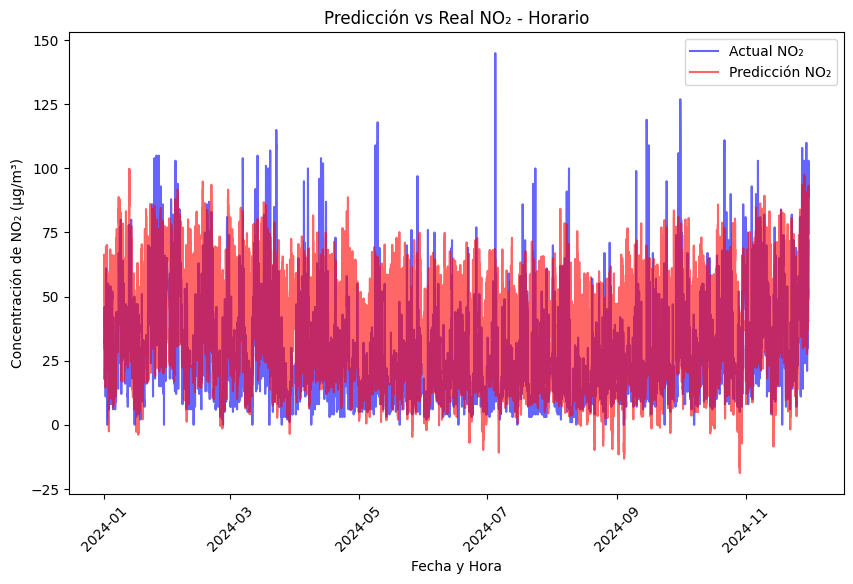

In [11]:
import matplotlib.pyplot as plt

# Predicciones del modelo
y_pred = gam.predict(X_test)

# Graficar valores reales vs. predicciones
plt.figure(figsize=(10, 6))
plt.plot(test_df['fecha'], y_test, label='Actual NO₂', color='blue', alpha=0.6)
plt.plot(test_df['fecha'], y_pred, label='Predicción NO₂', color='red', alpha=0.6)
plt.title('Predicción vs Real NO₂ - Horario')
plt.xlabel('Fecha y Hora')
plt.ylabel('Concentración de NO₂ (µg/m³)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_28061/866210126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['fecha_dia'] = test_df['fecha'].dt.date


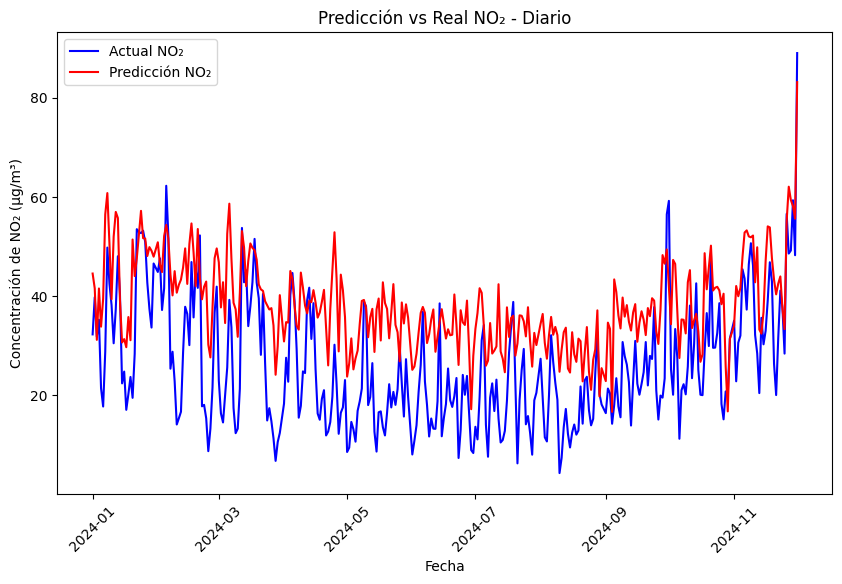

In [12]:
# Agrupar por día
test_df['fecha_dia'] = test_df['fecha'].dt.date
y_pred_daily = pd.DataFrame({'fecha_dia': test_df['fecha_dia'], 'pred': y_pred})
y_actual_daily = pd.DataFrame({'fecha_dia': test_df['fecha_dia'], 'actual': y_test})

# Agrupar por día y calcular la media
y_pred_daily_mean = y_pred_daily.groupby('fecha_dia').mean()
y_actual_daily_mean = y_actual_daily.groupby('fecha_dia').mean()

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(y_actual_daily_mean.index, y_actual_daily_mean['actual'], label='Actual NO₂', color='blue')
plt.plot(y_pred_daily_mean.index, y_pred_daily_mean['pred'], label='Predicción NO₂', color='red')
plt.title('Predicción vs Real NO₂ - Diario')
plt.xlabel('Fecha')
plt.ylabel('Concentración de NO₂ (µg/m³)')
plt.legend()
plt.xticks(rotation=45)
plt.show()
